In [ ]:
pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.datasets import make_classification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import seaborn as sns
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_text as text #intall using 'pip install tensorflow-text'

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/converted - Copy.csv')
data.head()

,text,label
0,these tiktoks radiate gay chaotic energy and i...,1
1,@Champions Again He got killed for using false...,1
2,It's not that all lives don't matter,1
3,Is it really that difficult to understand? Bla...,1
4,Whenever we say black isn't that racists? Why...,1


In [ ]:
data.shape

(22743, 2)

In [ ]:
data.label.value_counts()

1    20781
0     1962
Name: label, dtype: int64

In [ ]:
X = data.iloc[:,:-1]
y = data.label
X.head()

,text
0,these tiktoks radiate gay chaotic energy and i...
1,@Champions Again He got killed for using false...
2,It's not that all lives don't matter
3,Is it really that difficult to understand? Bla...
4,Whenever we say black isn't that racists? Why...


In [ ]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
X.loc[:,['text']] = \
X.loc[:,['text']].apply(enc.fit_transform)
X.head()

<ipython-input-10-7e2fafe9e82b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,['text']] = \


,text
0,21011
1,897
2,11073
3,10712
4,18228


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/converted - Copy.csv")
df = shuffle(df, random_state=22)
df.head(5)

,text,label
3925,I am so sad because the girl in the maroon swe...,1
4421,They already taken it our,1
12603,I mean I'm all for equality and all,0
3330,I'm in the closet as pansexual and non-binary,1
9214,they don't even care about blacks being racist...,1


In [ ]:
df.groupby('label').describe()

text                              
       count unique               top freq
label                                     
0       1962   1895  All Lives Matter   10
1      20781  19835            #NAME?   88

In [ ]:
df['label'].value_counts()

1    20781
0     1962
Name: label, dtype: int64

In [ ]:
1962/20781

0.09441316587267215

In [ ]:
df_hope = df[df['label']==0]
df_hope.shape

(1962, 2)

In [ ]:
df_nhope = df[df['label']==1]
df_nhope.shape

(20781, 2)

In [ ]:
df_nhope_downsampled = df_nhope.sample(df_hope.shape[0])
df_nhope_downsampled.shape

(1962, 2)

In [ ]:
df_balanced = pd.concat([df_hope, df_nhope_downsampled])
df_balanced.shape

(3924, 2)

In [ ]:
df_balanced['label'].value_counts()

0    1962
1    1962
Name: label, dtype: int64

In [ ]:
df_balanced.sample(5)

,text,label
19234,My mom’s an engineer. As a girl,0
22688,All people of good character matter,0
2005,@10 out of 10 She uses her platform. And we're...,0
7188,I'm a Christian and I believe in the Bible but...,0
21480,When i was a little girl i didn't like barbies...,0


In [ ]:
df_balanced['Category'] = df_balanced['label'].apply(lambda x: 'Hope' if x==0 else 'Non-hope')
df_balanced.sample(10)

,text,label,Category
12468,Most men in their professions will be very com...,1,Non-hope
7162,Good for her!,1,Non-hope
3775,Good thing that they factor in age,1,Non-hope
22026,@Damian Vigorito what's a 'novel priest prize'...,1,Non-hope
11879,@topgun032 THANK. YOU.,1,Non-hope
20147,Ya as someone who has worked in the IT feild I...,1,Non-hope
8835,All Lives Matter. Not Just Black.,0,Hope
12209,I’m a Christian but I agree and support homose...,0,Hope
10709,Revolutions eat themselves.,0,Hope
19386,@MiraiStar you can't disagree with a sexuality?,1,Non-hope


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['text'],data['label'], stratify=data['label'])

# BERT

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
#Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#NN layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
METRICS  = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
92/92 [==============================] - 1417s 15s/step - loss: 0.6753 - accuracy: 0.5838 - precision: 0.5877 - recall: 0.5602
Epoch 2/10
92/92 [==============================] - 1394s 15s/step - loss: 0.6275 - accuracy: 0.6510 - precision: 0.6590 - recall: 0.6254
Epoch 3/10
92/92 [==============================] - 1366s 15s/step - loss: 0.6067 - accuracy: 0.6707 - precision: 0.6768 - recall: 0.6533
Epoch 4/10
92/92 [==============================] - 1357s 15s/step - loss: 0.5916 - accuracy: 0.6857 - precision: 0.6875 - recall: 0.6805
Epoch 5/10
92/92 [==============================] - 1385s 15s/step - loss: 0.5747 - accuracy: 0.7064 - precision: 0.7080 - recall: 0.7022
Epoch 6/10
92/92 [==============================] - 1350s 15s/step - loss: 0.5629 - accuracy: 0.7061 - precision: 0.7053 - recall: 0.7077
Epoch 7/10
92/92 [==============================] - 1340s 15s/step - loss: 0.5559 - accuracy: 0.7102 - precision: 0.7105 - recall: 0.7090
Epoch 8/10
92/92 [================

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

31/31 [==============================] - 564s 18s/step


In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[276, 214],
       [ 66, 425]])

Text(50.722222222222214, 0.5, 'Truth')

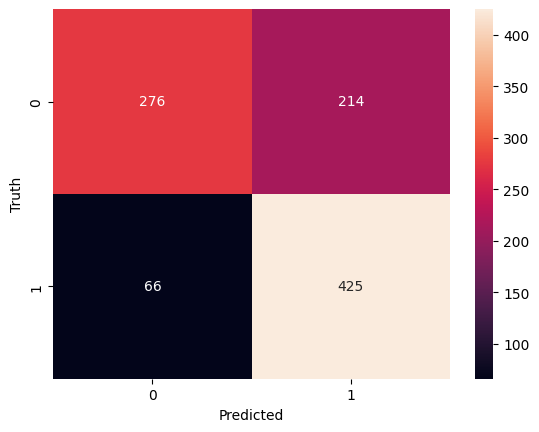

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.81      0.56      0.66       490
           1       0.67      0.87      0.75       491

    accuracy                           0.71       981
   macro avg       0.74      0.71      0.71       981
weighted avg       0.74      0.71      0.71       981

